# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math
import cv2

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Open camera
cap = cv2.VideoCapture(0)

In [6]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [7]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [8]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(945, 799), (1254, 799), (1254, 301), (945, 301)], [(497, 1080), (975, 1080), (975, 704), (497, 704)]]
Centroid de la goal area : [1631.5  574. ]
Vecteur direction du robot : 95 -4
Centroid du robot : [514 556]


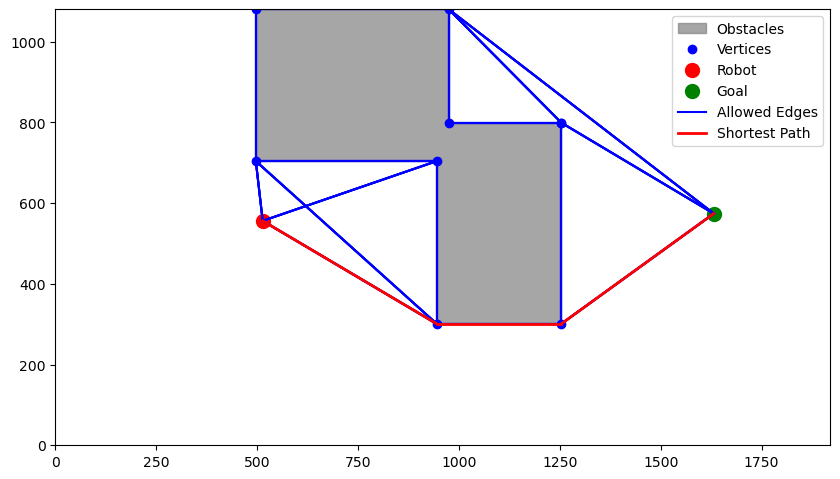

In [9]:
ret, frame = cap.read()

# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal(frame)
robot_centroid, robot_direction = vision.vision_robot(frame)

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot(frame)

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  x:  27.0 , y:  30.0 , angle:  -0.04208040744189057
Rotation state:
Robot angle:  [-0.04208041] , Goal angle:  [-0.52807445] , Rotation to achieve:  [-0.48599404]
Iteration :  2
Kalman:  x:  27.233704744565912 , y:  29.990159800228803 , angle:  -0.041730356505013964
Rotation state:
Robot angle:  [-0.04173036] , Goal angle:  [-0.53203617] , Rotation to achieve:  [-0.49030582]
Iteration :  3
Kalman:  x:  27.674385663101543 , y:  29.975994054137324 , angle:  -0.06515883887419727
Rotation state:
Robot angle:  [-0.06515884] , Goal angle:  [-0.53980853] , Rotation to achieve:  [-0.47464969]
Iteration :  4
Kalman:  x:  27.816218238711933 , y:  29.968518851479217 , angle:  -0.13055691275976464
Rotation state:
Robot angle:  [-0.13055691] , Goal angle:  [-0.5422649] , Rotation to achieve:  [-0.41170798]
Iteration :  5
Kalman:  x:  27.85431767381105 , y:  29.96291752213356 , angle:  -0.21404381356282548
Rotation state:
Robot angle:  [-0.21404381] , Goal angle:  [-0.5428148]

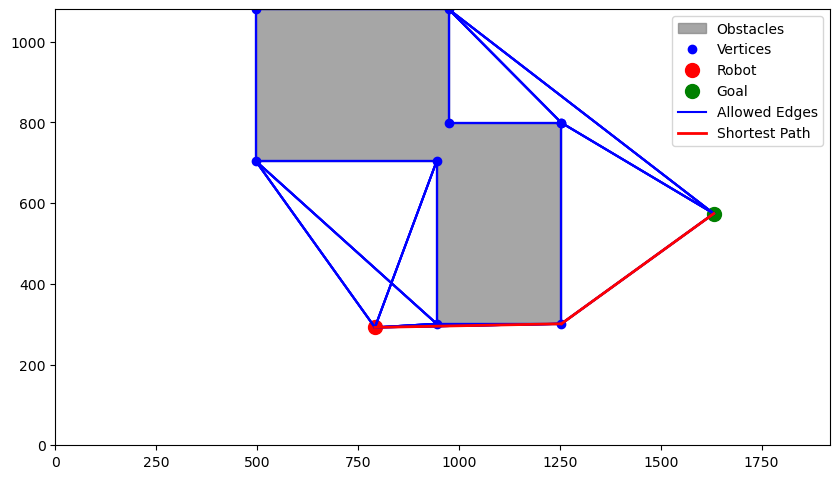

centroid camera:  (42, 15)
glob nav path : [(67, 16), (88, 31)]
Iteration :  39
Kalman:  x:  42.00066764325952 , y:  14.999732504773387 , angle:  -0.6660337792928998
Rotation state:
Robot angle:  [-0.66603378] , Goal angle:  [0.03999044] , Rotation to achieve:  [0.70602422]
Iteration :  40
Kalman:  x:  42.230205314111814 , y:  14.819356238674938 , angle:  -0.6692494775531886
Rotation state:
Robot angle:  [-0.66924948] , Goal angle:  [0.04762861] , Rotation to achieve:  [0.71687809]
Iteration :  41
Kalman:  x:  42.31891002812241 , y:  14.74785682267491 , angle:  -0.647848169750747
Rotation state:
Robot angle:  [-0.64784817] , Goal angle:  [0.05068944] , Rotation to achieve:  [0.69853761]
Iteration :  42
Kalman:  x:  42.37198337021713 , y:  14.706924727462896 , angle:  -0.588456267125522
Rotation state:
Robot angle:  [-0.58845627] , Goal angle:  [0.05245607] , Rotation to achieve:  [0.64091234]
Iteration :  43
Kalman:  x:  42.40226801620942 , y:  14.686956375706517 , angle:  -0.508579074

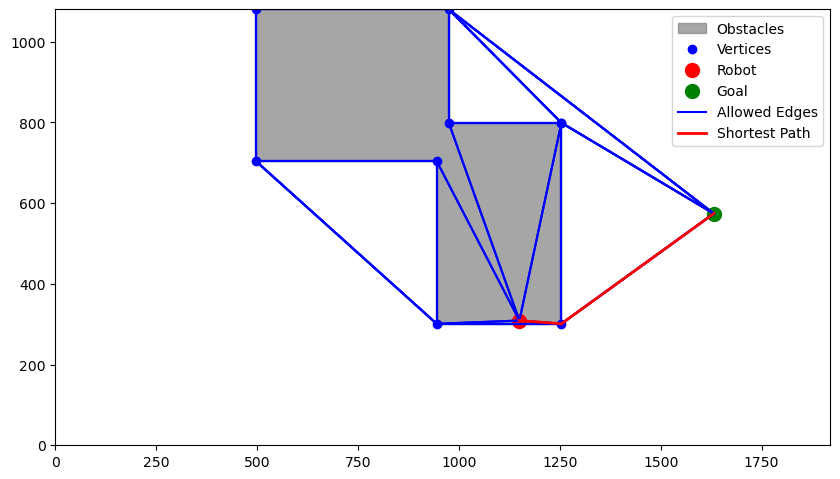

centroid camera:  (62, 16)
glob nav path : [(88, 31)]
Iteration :  75
Kalman:  x:  62.000503765004964 , y:  16.000148953831896 , angle:  0.0020388491277615606
Rotation state:
Robot angle:  [0.00203885] , Goal angle:  [0.52328241] , Rotation to achieve:  [0.52124356]
Iteration :  76
Kalman:  x:  63.05809665581473 , y:  16.00230285390334 , angle:  0.005276362994497645
Rotation state:
Robot angle:  [0.00527636] , Goal angle:  [0.54137868] , Rotation to achieve:  [0.53610232]
Iteration :  77
Kalman:  x:  63.77317288746916 , y:  15.99994749863059 , angle:  0.03110514907040891
Rotation state:
Robot angle:  [0.03110515] , Goal angle:  [0.55438188] , Rotation to achieve:  [0.52327673]
Iteration :  78
Kalman:  x:  64.04154670127227 , y:  16.005305125516585 , angle:  0.09389526451332592
Rotation state:
Robot angle:  [0.09389526] , Goal angle:  [0.55921922] , Rotation to achieve:  [0.46532396]
Iteration :  79
Kalman:  x:  64.15000124791129 , y:  16.016283657738647 , angle:  0.17548025432417877
Ro

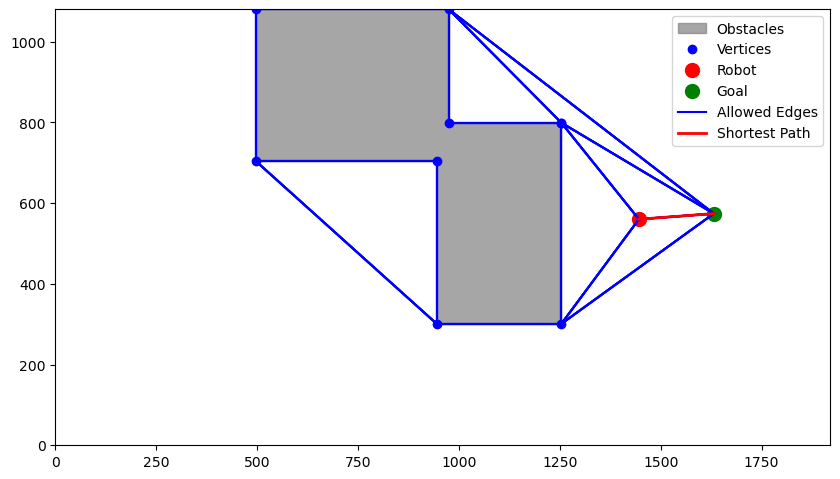

centroid camera:  (78, 30)
glob nav path : [(88, 31)]
Iteration :  114
Kalman:  x:  78.00066568846397 , y:  30.00044982912842 , angle:  0.8056417682243621
Rotation state:
Robot angle:  [0.80564177] , Goal angle:  [0.0996307] , Rotation to achieve:  [-0.70601106]
Iteration :  115
Kalman:  x:  78.29936486484179 , y:  30.311494250928945 , angle:  0.81111217611266
Rotation state:
Robot angle:  [0.81111218] , Goal angle:  [0.07085651] , Rotation to achieve:  [-0.74025567]
Iteration :  116
Kalman:  x:  78.43294886174152 , y:  30.45572989115998 , angle:  0.7900155059007243
Rotation state:
Robot angle:  [0.79001551] , Goal angle:  [0.0568288] , Rotation to achieve:  [-0.7331867]
Iteration :  117
Kalman:  x:  78.47019699928408 , y:  30.494303334899513 , angle:  0.7288986261914854
Rotation state:
Robot angle:  [0.72889863] , Goal angle:  [0.05301503] , Rotation to achieve:  [-0.67588359]
Iteration :  118
Kalman:  x:  78.4746836354515 , y:  30.498104535530267 , angle:  0.6478559124262845
Rotation

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 

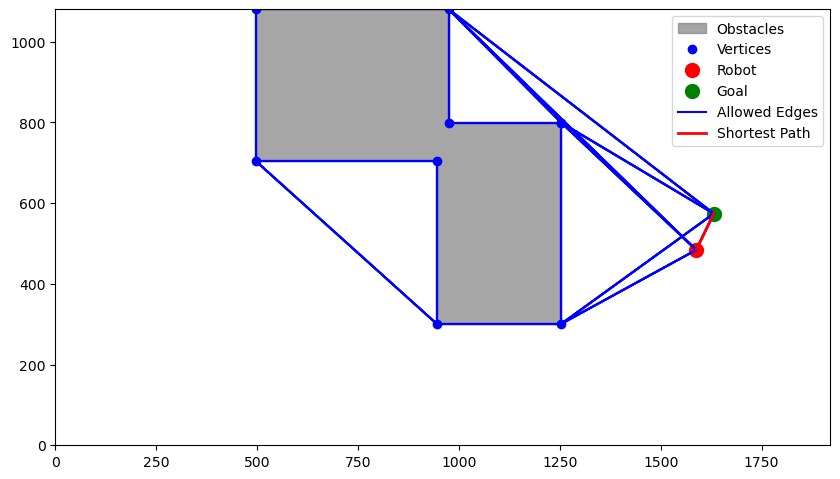

centroid camera:  (85, 26)
glob nav path : [(88, 31)]
Iteration :  138
Kalman:  x:  85.00043832006459 , y:  26.000070594900354 , angle:  -0.31011116107200065
Rotation state:
Robot angle:  [-0.31011116] , Goal angle:  [1.03043506] , Rotation to achieve:  [1.34054622]
Iteration :  139
Kalman:  x:  85.01891015268546 , y:  25.994152827503356 , angle:  -0.32386278693255605
Rotation state:
Robot angle:  [-0.32386279] , Goal angle:  [1.03367631] , Rotation to achieve:  [1.3575391]
Iteration :  140
Kalman:  x:  85.0294315605402 , y:  25.99040536261167 , angle:  -0.3074129084845525
Rotation state:
Robot angle:  [-0.30741291] , Goal angle:  [1.03555768] , Rotation to achieve:  [1.34297059]
Iteration :  141
Kalman:  x:  85.0386456518407 , y:  25.987399439305577 , angle:  -0.250632991960583
Rotation state:
Robot angle:  [-0.25063299] , Goal angle:  [1.03718232] , Rotation to achieve:  [1.28781531]
Iteration :  142
Kalman:  x:  85.05050658445232 , y:  25.98445862368501 , angle:  -0.1712641456348371

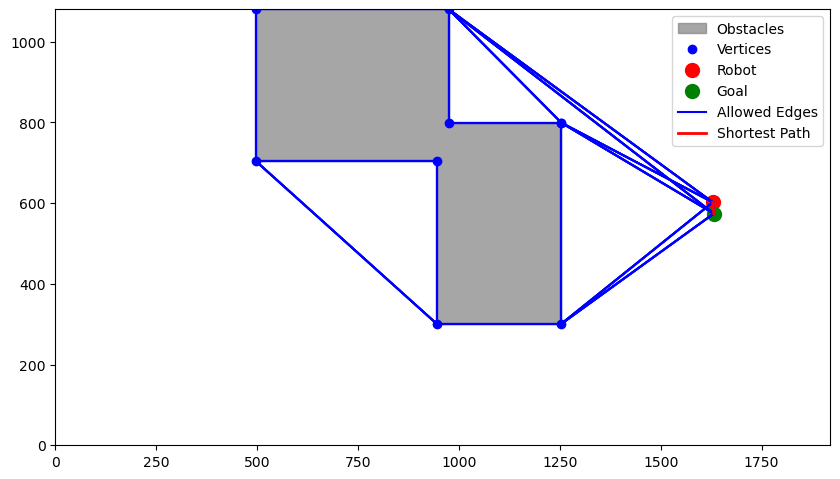

centroid camera:  (88, 32)
glob nav path : []
Iteration :  164
Thymio arrived in the goal area, congratulations!


In [10]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

old_time = 0.0
iter = 0


while(True):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman 
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    
    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

        
    #CA SERT A QUOI RAPH? A mettre dans une fonction?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        # Compute the difference between the robot direction and the direction of the goal
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], 
                           intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        # Define the turning orientation
        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

        # Check the orientation of the robot
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
        
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        # Check if the robot achieve the intermediate goal
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        # Check if the robot orientation change a lot from its goal direction
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0,0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            ret, frame = cap.read()
            robot_centroid, robot_direction = vision.vision_robot(frame)
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        
        # Convert in centimeter for the Kalman filter
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        # Delete the first goal because it's the robot position
        intermediate_goals.pop(0)
        
        # Check if the robot achieve the next goal, if yes it can target the next one
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        # Check if we detect an already known obstacle or an other one
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        # Add the new obstacle to the list
        obstacles.append(Object)
        prox_sensors_bool = True
        
        # The robot is backwarding in order to avoid the obstacle
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [32]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE